In [1]:
from functools import partial
import pickle as pkl
import yaml
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import soepy

from dev_library import plot_basics_choices
from dev_library import plot_basics_wages
from dev_library import df_alignment

In [2]:
fname = "/home/peisenha/structExpectations/data-exchange-sciebo/df-observed-data-weighted-subsample.pkl"
df_obs = pd.read_pickle(fname)

In [3]:
os.chdir("/home/peisenha/structExpectations/development/open-issues/high-education-issues")

I collect some behavior of the model worth investigating. In addition, this notebook documents two worriesome features in the predictions for the group of highly-educated women in our sample.

* Value for **Non_Consumption_Utility_N**

It appears that in simulated datasets it always has a value of one.

* Impact of changes to **child_6orolder_f** 

It appears that massive increases in the disutilty of work when having children does not do much to the decision to work fulltime. It shifts people from part-time working to staying at home.

* Impact **child_age_max** 

Increasing the age of the child for our utility shifter *6orolder* from 18 to 55 years does result in the expected patterns for the medium and low educated. However, there is nearly no behavioral response for the highly educated.

* Part-time wages

The wage among the highly educated individuals when working only part-time does exhibit considerable jumps.

## Value of **Non_Consumption_Utility_N**

In [4]:
model_params_start = pd.read_pickle("start.soepy.pkl")
df_sim_base = df_alignment(soepy.simulate(model_params_start, "resources/model_spec_init.yml"))
df_sim_base["Non_Consumption_Utility_N"].describe()

count    1950000.0
mean           1.0
std            0.0
min            1.0
25%            1.0
50%            1.0
75%            1.0
max            1.0
Name: Non_Consumption_Utility_N, dtype: float64

## Impact of changes to **child_6orolder_f** 


In [5]:
model_params_start = pd.read_pickle("start.soepy.pkl")
df_sim_base = df_alignment(soepy.simulate(model_params_start, "resources/model_spec_init.yml"))


model_params_high = model_params_start.copy()

model_params_high.loc[("disutil_work", "child_6orolder_f"), "value"] = +400.4
model_params_high.loc[("disutil_work", "child_6orolder_p"), "value"] = +400.4
df_sim_high = df_alignment(soepy.simulate(model_params_high, "resources/model_spec_init.yml"))

/home/peisenha/external-storage/sciebo/office/projects/structExpectations/development/submodules/soepy/soepy/shared/shared_auxiliary.py:170: RuntimeWarning: overflow encountered in exp
  non_consumption_utility = np.exp(non_consumption_utility)
/home/peisenha/external-storage/sciebo/office/projects/structExpectations/development/submodules/soepy/soepy/shared/shared_auxiliary.py:170: RuntimeWarning: overflow encountered in exp
  non_consumption_utility = np.exp(non_consumption_utility)


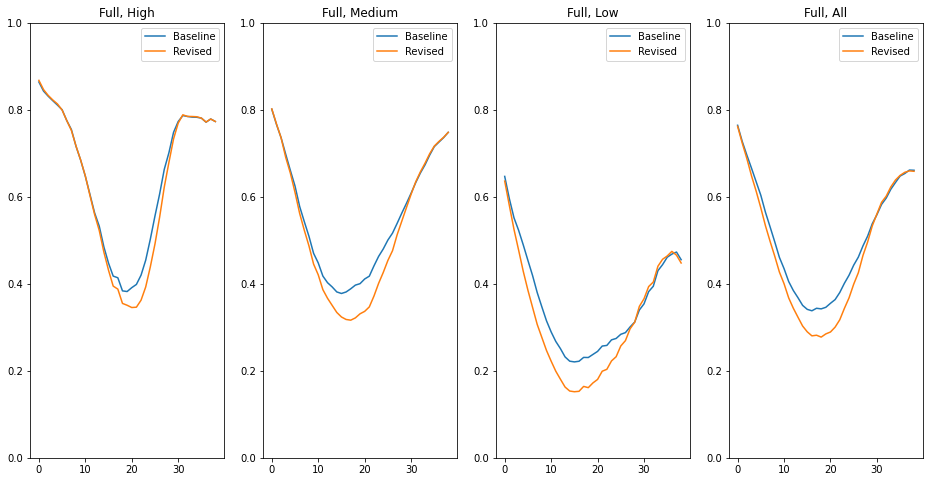

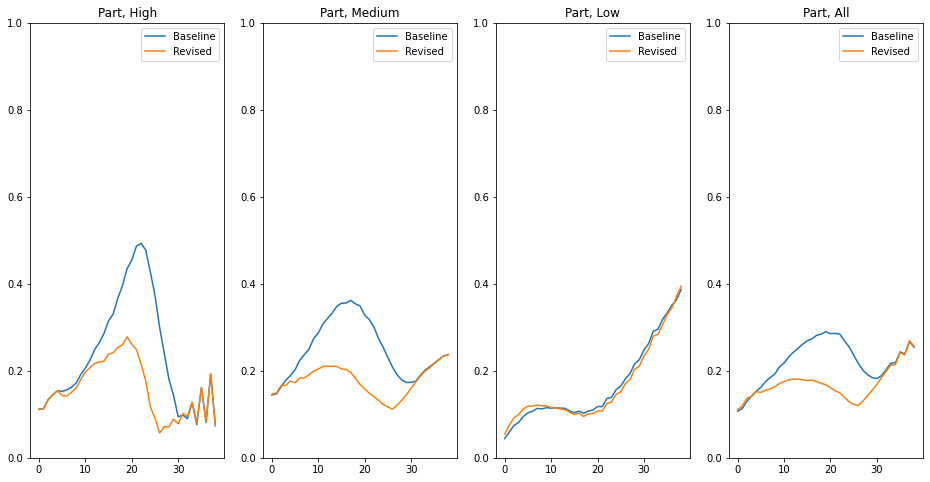

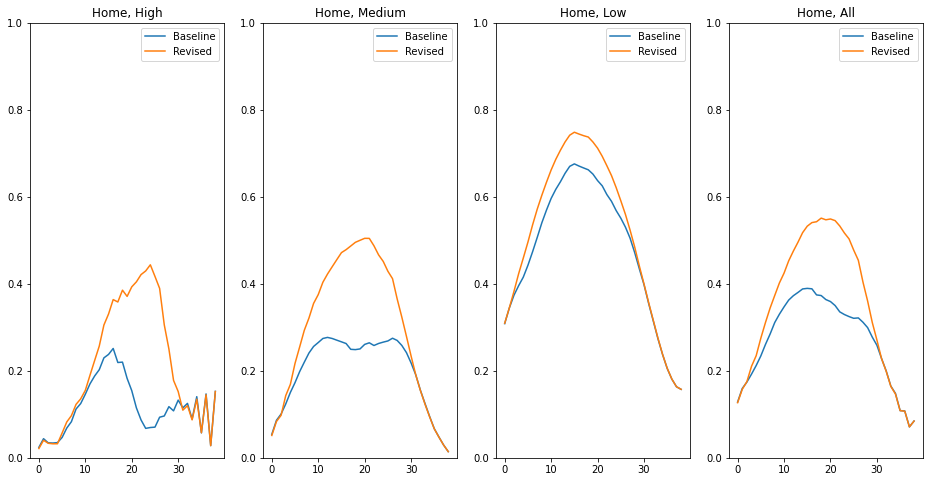

In [6]:
def plot_basics_choices(df_sim_base, df_sim_revs):

    for choice in ["Full", "Part", "Home"]:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(16, 8))

        for edu_level, ax in [
            ("High", ax1),
            ("Medium", ax2),
            ("Low", ax3),
            ("All", ax4),
        ]:

            if edu_level != "All":
                df_sim_base_subset = df_sim_base[df_sim_base["Education_Level"] == edu_level]
                df_sim_revs_subset = df_sim_revs[df_sim_revs["Education_Level"] == edu_level]
            else:
                df_sim_base_subset = df_sim_base
                df_sim_revs_subset = df_sim_revs

            y_base = (
                df_sim_base_subset.groupby("Period")
                .Choice.value_counts(normalize=True)
                .loc[(slice(None), choice)]
            )
            y_revs = (
                df_sim_revs_subset.groupby("Period")
                .Choice.value_counts(normalize=True)
                .loc[(slice(None), choice)]
            )

            x = df_sim_base.index.get_level_values("Period").unique()

            ax.plot(x, y_base, label="Baseline")
            ax.plot(x, y_revs, label="Revised")
            ax.legend()
            ax.set_ylim([0, 1])
            ax.set_title(f"{choice}, {edu_level}")
            
plot_basics_choices(df_sim_base, df_sim_high)

## Impact of **child_age_max**

I created two specification files. The two only differ in the **child_age_max** specification which is set to 55 in the revised file. We thus expect women to return working much less after they have children.

In [7]:
stat = yaml.load(open("resources/model_spec_init.yml"), Loader=yaml.Loader)["EXOG_PROC"]["child_age_max"]
print(f"Base: child_age_max is {stat}")

stat = yaml.load(open("resources/model_spec_init_revs.yml"), Loader=yaml.Loader)["EXOG_PROC"]["child_age_max"]
print(f"Base: child_age_max is {stat}")

Base: child_age_max is 18
Base: child_age_max is 55


I now simulate samples based on both model specification with the same parameters. 

In [8]:
model_params_start = pd.read_pickle("start.soepy.pkl")
df_sim_base = df_alignment(soepy.simulate(model_params_start, "resources/model_spec_init.yml"))
df_sim_revs = df_alignment(soepy.simulate(model_params_start, "resources/model_spec_init_revs.yml"))

Now we visualize the changes in choice behavior among the different educational groups.

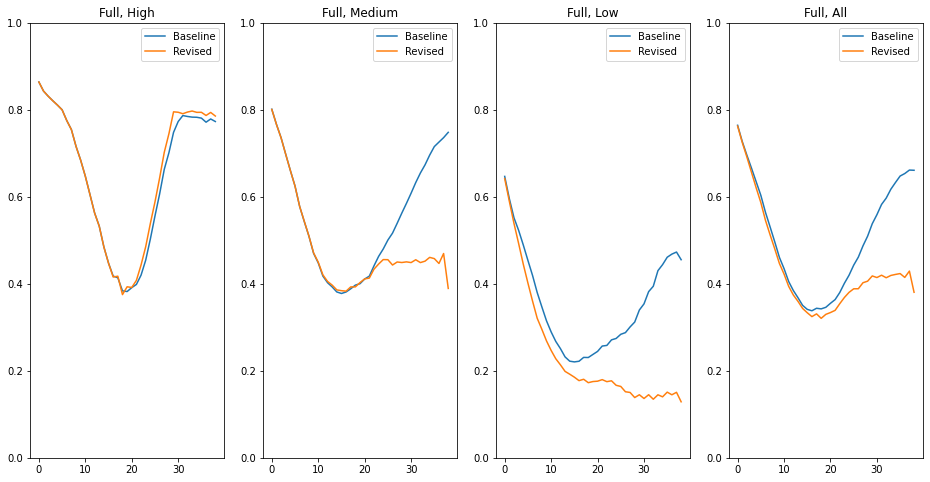

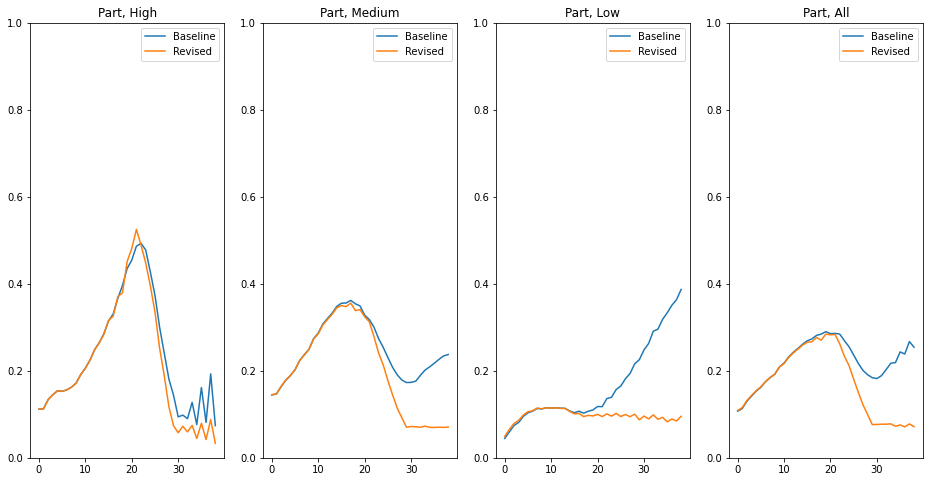

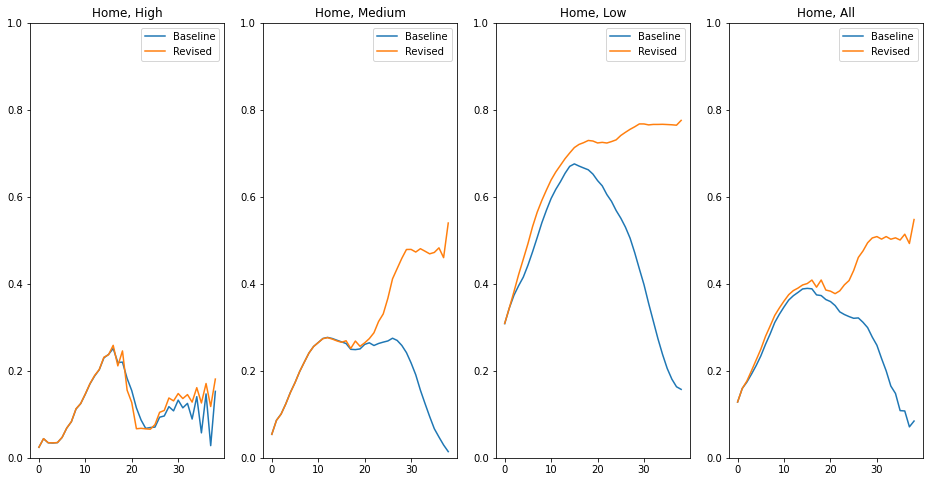

In [9]:
plot_basics_choices(df_sim_base, df_sim_revs)

There is the expected pattern overall, but nearly no response for the high educated.

## Part-time wages

I plot the average wages for all educational groups in full- and part-time

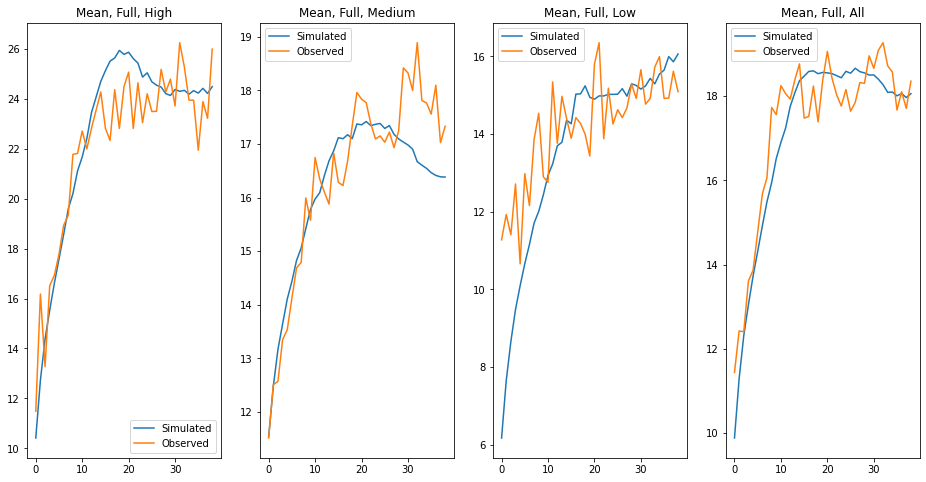

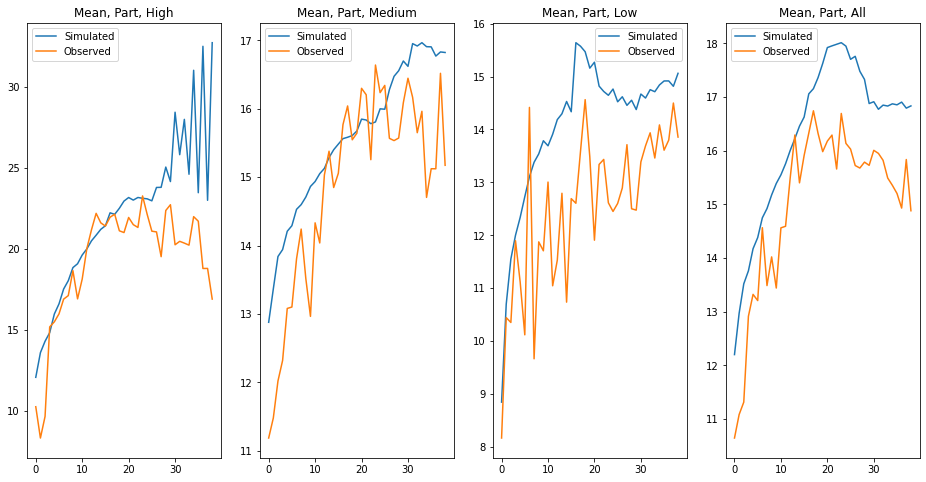

In [10]:
def plot_basics_wages(df_obs, df_sim):

    for work_level in ["Full", "Part"]:

        df_sim_work_level = df_sim[df_sim["Choice"] == work_level]
        df_obs_work_level = df_obs[df_obs["Choice"] == work_level]

        df_obs_work_level = df_obs_work_level.astype({"Wage_Observed": np.float})

        fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(16, 8))

        for edu_level, ax in [
            ("High", ax1),
            ("Medium", ax2),
            ("Low", ax3),
            ("All", ax4),
        ]:

            if edu_level != "All":
                df_sim_subset = df_sim_work_level[
                    df_sim_work_level["Education_Level"] == edu_level
                ]
                df_obs_subset = df_obs_work_level[
                    df_obs_work_level["Education_Level"] == edu_level
                ]
            else:
                df_sim_subset = df_sim_work_level
                df_obs_subset = df_obs_work_level

            y_sim = df_sim_subset.groupby("Period")["Wage_Observed"].mean()
            y_obs = df_obs_subset.groupby("Period")["Wage_Observed"].mean()

            x = df_sim.index.get_level_values("Period").unique()

            ax.plot(x, y_sim, label="Simulated")
            ax.plot(x, y_obs, label="Observed")
            ax.legend()
            ax.set_title(f"Mean, {work_level}, {edu_level}")

plot_basics_wages(df_obs, df_sim_base)


All wage profiles look as to be expected, besides the part-time wage among the highly educated. The jumps in average wages among the highly educated that work part-tme are huge.

* I investigated whether it is just a small sample, but the number of individuals is several hundred.